## Vanilla ResNet-34 Implementation

**AIM: Build and train an image classifier to detect images from different animal species using a Custom RestNet-34 Model in TensorFlow.**

### Objectives

- Data visualisation
- Data preprocessing and image augmentation
- Replicate the ResNet-34 architecture for model development.
- Compile and train the model
- Add early stopping callback (optional
- Save and load the model
- Model evaluation.
- Make predictions on new data using the trained model.

### Pre-requisite
- Google collaboratry or Jupyter Notebook
- animal-image-classification-dataset
- TensorFlow2

In [18]:
# Basic imports
import os
import sys
import random
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

In [19]:
# Set seed for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [20]:
# Check CPU availability
!nvidia-smi

Mon Jan 26 20:59:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8              6W /  110W |       9MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
# Check number of GPUs

gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
# Check TensorFlow version
print("TensorFlow Version", tf.__version__)

TensorFlow Version 2.20.0


In [23]:
# Set training data directory
base_dir = "../dataset/animal_image_classification_dataset"
base_dir = pathlib.Path(base_dir)

base_dir

PosixPath('../dataset/animal_image_classification_dataset')

In [24]:
# Training directory
train_dir = base_dir / "Training Data" / "Training Data"
train_dir

PosixPath('../dataset/animal_image_classification_dataset/Training Data/Training Data')

In [25]:
# Validation directory
validation_dir = base_dir / "Validation Data" / "Validation Data"
validation_dir

PosixPath('../dataset/animal_image_classification_dataset/Validation Data/Validation Data')

In [26]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 64
EPOCHS = 300

In [27]:
# Load the dataset

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
)

Found 30000 files belonging to 15 classes.


I0000 00:00:1769457563.144768   35257 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6624 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [28]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 15 classes.


In [29]:
class_names = train_dataset.class_names
class_names

['Beetle',
 'Butterfly',
 'Cat',
 'Cow',
 'Dog',
 'Elephant',
 'Gorilla',
 'Hippo',
 'Lizard',
 'Monkey',
 'Mouse',
 'Panda',
 'Spider',
 'Tiger',
 'Zebra']

In [30]:
# Number of classes
number_classes = len(class_names)
print("Total number of classes: ", number_classes)

Total number of classes:  15


### Sannity Check
**Confirms correct labels for images, detects corrupt images and verifies colour channels, orientation and resolution of images**

In [31]:
# This captures exactly one batch from the dataset
train_dataset.take(1)


<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
# Capture exactly one batch and store it in memory.
# This freezes the random augmentation for this specific set of images
for images, labels in train_dataset.take(1):
    fixed_images = images.numpy()
    fixed_labels = labels.numpy()

2026-01-26 20:59:24.980457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


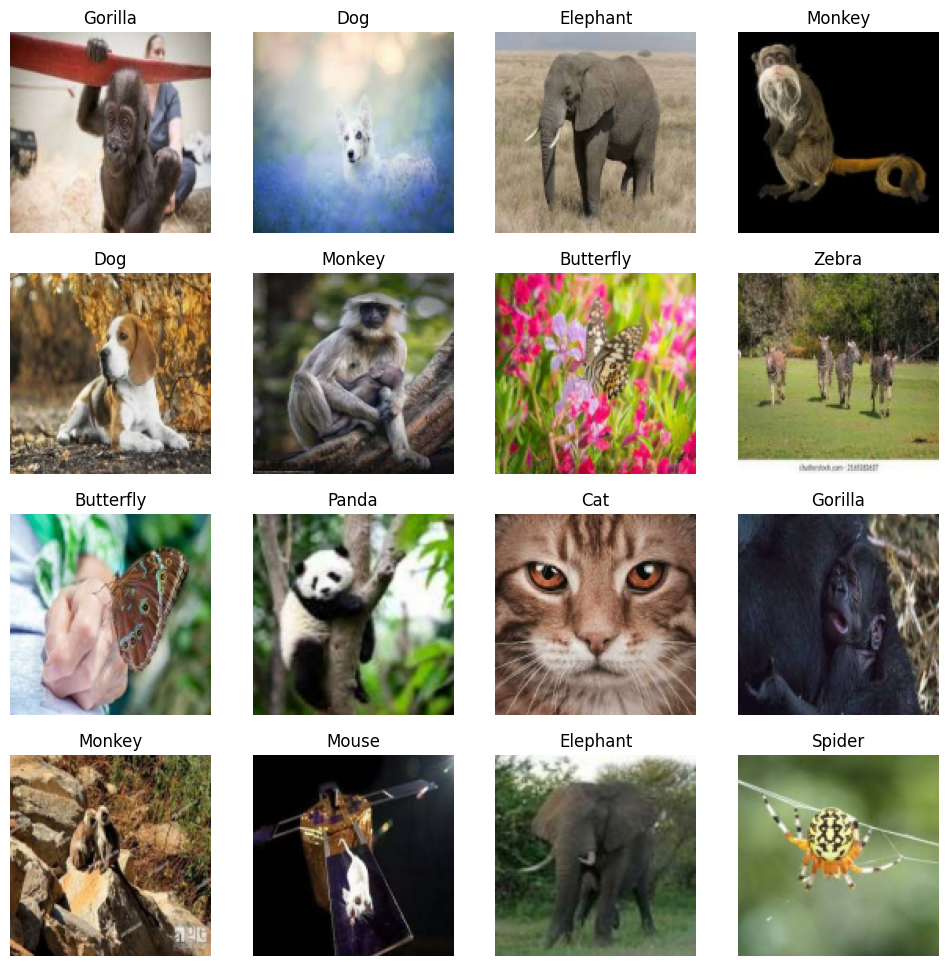

In [33]:
# Visualisation
# No matter how many times you run this cell, the images won't change
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fixed_images[i].astype("uint8"))
    plt.title(class_names[fixed_labels[i]])
    plt.axis("off")

### Performance Optimisation using Autotune

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

In [35]:
validation_dataset = (
    validation_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Vanilla ResNet Implementation

In [36]:
# Data augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("hotizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1)
])

In [37]:
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3,)
INPUT_SHAPE

(128, 128, 3)

In [38]:
# Identity Block Implementation
# NOTE: Identity block is used when the input and output have teh same spatial size 
# and have the same number of channels.

def identity_block(x, filters):
    shortcut = x

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation("relu")(x)

    return x

In [39]:
# Projection (Convolutional) Block
# NOTE: Projection block is used when spatial size differs and 
# and channel count differs.

def projection_block(x, filters, stride):
    shortcut = tf.keras.layers.Conv2D(
        filters, (1, 1), strides=stride, padding="same"
    )(x)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    x = tf.keras.layers.Conv2D(
        filters, (3, 3), strides=stride, padding="same"
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.Activation("relu")(x)

    return x


In [40]:
# Full ResNet Implementation
# This is an exact implementation of the ResNe-34 Model

inputs = tf.keras.Input(shape=INPUT_SHAPE)

In [41]:
# Initial Layers

x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, padding="same")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding="same")(x)

In [42]:
# Stage 2 (64 Filters)
# 1 Projection block and 2 Identity blocks
x = projection_block(x, 64, stride=1)
x = identity_block(x, 64)
x = identity_block(x, 64)

In [43]:
# Stage 3 (128 filters)
# 1 Projection block and 3 Identity blocks
x = projection_block(x, 128, stride=2)
x = identity_block(x, 128)
x = identity_block(x, 128)
x = identity_block(x, 128)

In [44]:
# Stage 4 (256 filters)
# 1 Projection block and 5 Identity blocks
x = projection_block(x, 256, stride=2)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)

In [45]:
# Stage 5 (512 filters)
x = projection_block(x, 512, stride=2)
x = identity_block(x, 512)
x = identity_block(x, 512)

In [46]:
# Classification head
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(number_classes, activation="softmax")(x)

In [47]:
# Create Model
model = tf.keras.Model(inputs, outputs)

In [48]:
# View Model Summar
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 21,322,319 (81.34 MB)

 Trainable params: 21,305,167 (81.27 MB)

 Non-trainable params: 17,152 (67.00 KB)

In [49]:
!pip show pydot

Name: pydot
Version: 1.4.2
Summary: Python interface to Graphviz's Dot
Home-page: https://github.com/pydot/pydot
Author: Ero Carrera
Author-email: ero.carrera@gmail.com
License: MIT
Location: /home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages
Requires: pyparsing
Required-by: apache-beam


In [50]:
!pip show graphviz

Name: graphviz
Version: 0.20.3
Summary: Simple Python interface for Graphviz
Home-page: https://github.com/xflr6/graphviz
Author: Sebastian Bank
Author-email: sebastian.bank@uni-leipzig.de
License: MIT
Location: /home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages
Requires: 
Required-by: catboost


In [51]:
tf.keras.utils.plot_model(
    model,
    to_file="Vanilla_ResNet34_architecture.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB"
)

In [52]:
# Compile Model
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [53]:
# Configure Callbacks

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/vanilla_resnet34_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    factor=0.3,
    verbose=1
)

callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]


In [54]:
# Train the Model to learn patterns from the image

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/300


2026-01-26 20:59:57.092730: I external/local_xla/xla/service/service.cc:163] XLA service 0x7aba64002320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-26 20:59:57.092745: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2026-01-26 20:59:57.544186: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-26 21:00:00.156418: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90501
2026-01-26 21:00:01.064815: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

  1/469 ━━━━━━━━━━━━━━━━━━━━ 4:24:21 34s/step - accuracy: 0.0625 - loss: 4.3986

I0000 00:00:1769457610.427758   35508 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/469 ━━━━━━━━━━━━━━━━━━━━ 31s 115ms/step - accuracy: 0.1905 - loss: 2.8945

2026-01-26 21:00:36.123611: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[48,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[48,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-26 21:00:36.289560: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[48,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[48,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2619 - loss: 2.5091

2026-01-26 21:01:21.483717: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-26 21:01:21.592435: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,128,16,16]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target


Epoch 1: val_accuracy improved from None to 0.14500, saving model to models/vanilla_resnet34_model.keras

Epoch 1: finished saving model to models/vanilla_resnet34_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 158ms/step - accuracy: 0.3599 - loss: 2.0593 - val_accuracy: 0.1450 - val_loss: 3.4748 - learning_rate: 0.0010
Epoch 2/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5247 - loss: 1.4944
Epoch 2: val_accuracy improved from 0.14500 to 0.27650, saving model to models/vanilla_resnet34_model.keras

Epoch 2: finished saving model to models/vanilla_resnet34_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 56s 120ms/step - accuracy: 0.5472 - loss: 1.4171 - val_accuracy: 0.2765 - val_loss: 2.9363 - learning_rate: 0.0010
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.6265 - loss: 1.1815
Epoch 3: val_accuracy did not improve from 0.27650
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 116ms/step - accuracy: 0.6268 - loss: 1.1753 - val_accuracy: 0.1870 - val_loss: 17.8806 - lea

In [55]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))


    plt.figure(figsize=(18, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


In [56]:
loss, accuracy = model.evaluate(validation_dataset)

print(f"Model Loss: {loss:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7031 - loss: 1.0443

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6925 - loss: 1.1369
Model Loss: 1.14
Model Accuracy: 0.69
